**Исследование семантических связей в текстах об искусстве с помощью Word2Vec**


Для обучения модели Word2Vec был собран специализированный текстовый корпус. В качестве источника данных использовались статьи из Википедии, относящиеся к тематике искусства. Из текстов был взят только раздел "Описание".

Для оптимизации Word2Vec была использована библиотека Gensim. Она позволяет легко обучать, сохранять и загружать модели Word2Vec, а также получать векторные представления слов и находить семантически похожие слова.

In [ ]:
# Установка необходимых библиотек
!pip install scipy gensim

!pip install nltk
!pip install scikit-learn
!pip install matplotlib
!pip install wikipedia

# Установка русской модели spaCy
!python -m spacy download ru_core_news_md

print("All remaining installations requested.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 MB 19.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
All remaining installations requested.


Для задач NLP была использова библиотека Spacy

In [ ]:
import os
import re
import spacy
from spacy.lang.ru import Russian
from spacy.lang.ru.stop_words import STOP_WORDS
from bs4 import BeautifulSoup
import wikipedia
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import sys

In [ ]:
# Настройка SpaCy
# Загрузка русской модели spaCy
nlp = spacy.load("ru_core_news_md")
print("Русская модель spaCy (ru_core_news_md) загружена.")

Русская модель spaCy (ru_core_news_md) загружена.


In [ ]:
# Настройка языка
wikipedia.set_lang("ru")

output_dir = "corpus_painting" # Создаем папку для корпуса
os.makedirs(output_dir, exist_ok=True)

Корпус состоит из 1000 вложений формата .txt, который был собран по ключевым словам "живопись", "художник", "картина", "искусство", "музей",
    "импрессионизм", "авангард", "ренессанс", "барокко" и т.д.

In [ ]:
start_categories = ["Категория:Живопись"]
processed_categories = set()
collected_articles = set()
articles_count = 0
max_articles = 1000

# Функция для получения статей из категории
def get_articles_from_category(category_name):
    print(f"Обработка категории: {category_name}")
    try:
        # Получаем страницы и подкатегории
        cat_pages = wikipedia.page(category_name)
        return list(cat_pages.links)

def get_articles_by_keyword_and_filter(keyword, max_results=100):
    global articles_count
    results = wikipedia.search(keyword, results=max_results)

    for title in results:
        if articles_count >= max_articles:
            break
        if title in collected_articles:
            continue
        try:
            page = wikipedia.page(title, auto_suggest=False)

            # Проверяем, относится ли статья к живописи по её категориям
            is_painting_related = False
            for category in page.categories:
                if "живопись" in category.lower() or \
                   "художник" in category.lower() or \
                   "картины" in category.lower() or \
                   "искусство" in category.lower() and "изобразительное" in category.lower():
                    is_painting_related = True
                    break

            if is_painting_related and len(page.content) > 500: # Пропускаем очень короткие статьи
                clean_text = clean_wiki_text(page.content)
                file_name = os.path.join(output_dir, f"{title.replace('/', '_').replace(':', '_')}.txt")
                with open(file_name, "w", encoding="utf-8") as f:
                    f.write(clean_text)
                collected_articles.add(title)
                articles_count += 1
                print(f"[{articles_count}/{max_articles}] Сохранена статья: {title}")
        except wikipedia.exceptions.DisambiguationError as e:
            pass
        except wikipedia.exceptions.PageError:
            # print(f"Страница не найдена: {title}")
            pass
        except Exception as e:
            # print(f"Ошибка при обработке статьи {title}: {e}")
            pass

def clean_wiki_text(text):
    # Удаляем секции типа "См. также", "Примечания", "Ссылки" и т.д.
    text = re.sub(r'\n== См. также ==.*', '', text, flags=re.DOTALL)
    text = re.sub(r'\n== Примечания ==.*', '', text, flags=re.DOTALL)
    text = re.sub(r'\n== Ссылки ==.*', '', text, flags=re.DOTALL)
    text = re.sub(r'\n== Литература ==.*', '', text, flags=re.DOTALL)
    text = re.sub(r'\n== Источники ==.*', '', text, flags=re.DOTALL)
    text = re.sub(r'\n== Галерея ==.*', '', text, flags=re.DOTALL)
    text = re.sub(r'\n== Награды ==.*', '', text, flags=re.DOTALL)
    text = re.sub(r'\n== Биография ==.*', '', text, flags=re.DOTALL) # Для художников
    text = re.sub(r'\n== Творчество ==.*', '', text, flags=re.DOTALL) # Для художников
    text = re.sub(r'\n== Фильмография ==.*', '', text, flags=re.DOTALL) # Может быть в биографиях

    # Удаляем содержимое скобок (особенно ссылки [[]])
    text = re.sub(r'\[\[.*?\]\]', '', text) # Внутренние ссылки
    text = re.sub(r'\{\{.*?\}\}', '', text) # Шаблоны
    text = re.sub(r'\(.*?\)', '', text)    # Текст в скобках

    # Удаляем несколько последовательных переносов строк
    text = re.sub(r'\n\n+', '\n\n', text)

    # Удаляем лишние пробелы
    text = re.sub(r' +', ' ', text)

    return text.strip()

# Список ключевых слов для поиска. Будем брать 100 результатов по каждому и проверять их категории на релевантность "живописи".
keywords = [
    "живопись", "художник", "картина", "искусство", "музей",
    "импрессионизм", "авангард", "ренессанс", "барокко", "реализм", "абстракционизм",
    "пейзаж", "портрет", "натюрморт"
]

print("Начинаем сбор корпуса...")
for keyword in keywords:
    if articles_count >= max_articles:
        break
    print(f"\nПоиск по ключевому слову: '{keyword}'")

    get_articles_by_keyword_and_filter(keyword, max_results=200)

print(f"\nСбор корпуса завершен. Собрано {articles_count} статей в папке '{output_dir}'.")

Начинаем сбор корпуса...

Поиск по ключевому слову: 'живопись'
[1/1000] Сохранена статья: Живопись
[2/1000] Сохранена статья: Монументальная живопись
[3/1000] Сохранена статья: Раджпутская живопись
[4/1000] Сохранена статья: Станковая живопись
[5/1000] Сохранена статья: Персидская живопись
[6/1000] Сохранена статья: Пещерная живопись
[7/1000] Сохранена статья: Китайская живопись
[8/1000] Сохранена статья: Реализм (живопись)
[9/1000] Сохранена статья: Русская живопись
[10/1000] Сохранена статья: Жанровая живопись
[11/1000] Сохранена статья: Испанская живопись XVII века


/usr/local/lib/python3.11/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.11/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


[12/1000] Сохранена статья: Историческая живопись
[13/1000] Сохранена статья: Мифологическая живопись
[14/1000] Сохранена статья: Альфрейная живопись
[15/1000] Сохранена статья: Японская живопись
[16/1000] Сохранена статья: Живопись майя
[17/1000] Сохранена статья: Могольская живопись
[18/1000] Сохранена статья: Живопись Тибета
[19/1000] Сохранена статья: Уинстон Черчилль и живопись
[20/1000] Сохранена статья: Живопись Нидерландов
[21/1000] Сохранена статья: Танка (живопись)
[22/1000] Сохранена статья: Барокко в живописи
[23/1000] Сохранена статья: Корейская живопись
[24/1000] Сохранена статья: Подрамник (живопись)
[25/1000] Сохранена статья: Живопись индейцев
[26/1000] Сохранена статья: Цифровая живопись
[27/1000] Сохранена статья: Живопись по стеклу
[28/1000] Сохранена статья: Итальянская живопись эпохи Возрождения
[29/1000] Сохранена статья: Рисунки и живопись Лермонтова
[30/1000] Сохранена статья: Древнеримская стенопись
[31/1000] Сохранена статья: Золотой век голландской живописи


Предобработка корпуса

In [ ]:
corpus_dir = "corpus_painting"
processed_corpus_path = "processed_sentences.txt"

def load_spacy_model():
    try:
        # Пытаемся загрузить среднюю модель (лучшее качество)
        nlp = spacy.load("ru_core_news_md")
        print("Загружена средняя модель ru_core_news_md")
        return nlp
    except OSError:

# Загрузка модели spaCy
nlp = load_spacy_model()
if nlp is None:
    exit(1)

Загружена средняя модель ru_core_news_md


In [ ]:
def preprocess_text(text):
    # 1. Приведение к нижнему регистру
    text = text.lower()

    # 2. Удаление пунктуации и специальных символов (сохраняем буквы, цифры и пробелы)
    text = re.sub(r'[^а-яa-zёЁ0-9\s]', ' ', text)

    # 3. Удаление множественных пробелов
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def tokenize_and_lemmatize(text):
    doc = nlp(text)
    lemmatized_words = []

    for token in doc:
        # Пропускаем стоп-слова, пунктуацию, пробелы и слишком короткие слова
        if (not token.is_stop and
            not token.is_punct and
            not token.is_space and
            len(token.text) > 2 and
            token.text.lower() not in STOP_WORDS):
            lemmatized_words.append(token.lemma_.lower())

    return lemmatized_words

all_sentences = []

print("Начинаем предобработку корпуса...")
processed_files = 0

for filename in os.listdir(corpus_dir):
    if filename.endswith(".txt"):
        filepath = os.path.join(corpus_dir, filename)
        try:
            with open(filepath, "r", encoding="utf-8") as f:
                text = f.read()

                # 1. Предварительная очистка
                cleaned_text = preprocess_text(text)

                # 2. Разделение на предложения с помощью spaCy
                doc = nlp(cleaned_text)

                for sent in doc.sents:
                    # 3. Токенизация и лемматизация
                    processed_words = tokenize_and_lemmatize(sent.text)
                    if processed_words:
                        all_sentences.append(processed_words)

            processed_files += 1
            if processed_files % 50 == 0:
                print(f"Обработано файлов: {processed_files}")

        except Exception as e:
            print(f"Ошибка обработки файла {filename}: {str(e)}")
            continue

print(f"\nПредобработка завершена. Обработано файлов: {processed_files}")
print(f"Всего получено предложений: {len(all_sentences)}")

# Сохраняем обработанные предложения
with open(processed_corpus_path, "w", encoding="utf-8") as f:
    for sentence in all_sentences:
        f.write(" ".join(sentence) + "\n")

print(f"\nОбработанные предложения сохранены в '{processed_corpus_path}'")

Начинаем предобработку корпуса...
Обработано файлов: 50
Обработано файлов: 100
Обработано файлов: 150
Обработано файлов: 200
Обработано файлов: 250
Обработано файлов: 300
Обработано файлов: 350
Обработано файлов: 400
Обработано файлов: 450
Обработано файлов: 500
Обработано файлов: 550
Обработано файлов: 600
Обработано файлов: 650
Обработано файлов: 700
Обработано файлов: 750
Обработано файлов: 800
Обработано файлов: 850
Обработано файлов: 900
Обработано файлов: 950
Обработано файлов: 1000

Предобработка завершена. Обработано файлов: 1030
Всего получено предложений: 1074

Обработанные предложения сохранены в 'processed_sentences.txt'


In [ ]:
# Сохраняем обработанные предложения в созданный файл.
# Каждая строка файла будет представлять собой предложение, а слова в предложении будут разделены пробелами. Это удобно для Gensim, который может читать предложения из файла.
with open(processed_corpus_path, "w", encoding="utf-8") as f:
    for sentence in all_sentences:
        f.write(" ".join(sentence) + "\n")

print(f"Обработанные предложения сохранены в '{processed_corpus_path}'.")

Обработанные предложения сохранены в 'processed_sentences.txt'.


In [ ]:
processed_corpus_path = "processed_sentences.txt"

print(f"Первые 10 строк обработанного корпуса из файла '{processed_corpus_path}':\n")
with open(processed_corpus_path, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        if i >= 30:  # Печатаем первые 30 строк
            break
        print(line.strip())

Первые 10 строк обработанного корпуса из файла 'processed_sentences.txt':

александер коземанс южно нидерландский живописец мастер натюрморт стиль фламандский барокко писать композиция цвет плод натюрморт жанр vanitas типично фламандский показной натюрморты
йозеф матей вратил чешский живописец навратил родиться слани 1798 год учиться отец декоратор закончить пражский академия художество совершать поездка граница швейцария основный жанр работа декоративный роспись пейзаж натюрморты жанровый сцена работа отличаться тонкий живописный манера посмертно пройти первый выставка работа 1909 год рудольфинуме
тайный вечеря фреска работа козимо росселли бьяджо антонио написать период 1480 1482 расположена сикстинский капелла ватикан история октябрь 1480 год росселли вместе флорентийский художник число доменико гирландайо сандро боттичелли приехать рим пригласить участие проект примирение лоренцо медичи фактический правитель флорентийский республика папа сикстом весна 1481 год флорентиец приступить

Теперь можно переходить к обучению модели Word2Vec
Цель: Обучить Word2Vec модель на нашем подготовленном корпусе (processed_sentences.txt)

In [ ]:
sys.setrecursionlimit(2000) # предосторожность

# Путь к обработанному корпусу
processed_corpus_path = "processed_sentences.txt"
# Путь для сохранения обученной модели
model_path = "word2vec_painting_model.bin"

# Загрузка предложений из файла
print(f"Загружаем предложения из файла: '{processed_corpus_path}'...")
sentences = LineSentence(processed_corpus_path)

# Определение параметров модели
vector_size = 300   # Размерность векторов
window = 5          # Размер окна контекста
min_count = 5       # Игнорировать слова, встречающиеся реже 5 раз
sg = 1              # Skip-gram (1) или CBOW (0)
epochs = 10         # Количество эпох обучения
workers = os.cpu_count() - 1 if os.cpu_count() > 1 else 1 # Используем все ядра ЦПУ кроме одного

print(f"  vector_size={vector_size}")
print(f"  window={window}")
print(f"  min_count={min_count}")
print(f"  sg={'Skip-gram' if sg == 1 else 'CBOW'}")
print(f"  epochs={epochs}")
print(f"  workers={workers}")

# Обучение модели
model = Word2Vec(
    sentences=sentences,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    sg=sg,
    epochs=epochs,
    workers=workers,
    compute_loss=True
)

print("\nОбучение модели завершено.")

# Сохранение обученной модели
model.save(model_path)
print(f"Модель сохранена в: '{model_path}'.")

Загружаем предложения из файла: 'processed_sentences.txt'...
  vector_size=300
  window=5
  min_count=5
  sg=Skip-gram
  epochs=10
  workers=1

Обучение модели завершено.
Модель сохранена в: 'word2vec_painting_model.bin'.


Загружаем модель Word2Vec из: 'word2vec_painting_model.bin'...
Модель успешно загружена.

--- Поиск ближайших слов ---

Слова, похожие на 'картина':
  дозор: 0.591
  подлинник: 0.579
  полотно: 0.574
  ода: 0.573
  черемисский: 0.569
  зарисовками: 0.568
  мунк: 0.567
  двойка: 0.565
  брюлловым: 0.564
  130: 0.563
------------------------------

Слова, похожие на 'художник':
  скульптор: 0.523
  живописец: 0.512
  андеграунд: 0.495
  кубистический: 0.490
  жюля: 0.488
  самоучка: 0.481
  тернера: 0.480
  мэтр: 0.479
  впечатлить: 0.479
  кинематографист: 0.479
------------------------------

Слова, похожие на 'цвет':
  тон: 0.610
  киноварь: 0.608
  ультрамарин: 0.602
  пигментами: 0.601
  оттенок: 0.600
  жёлтый: 0.599
  зелёный: 0.597
  оранжевый: 0.595
  золотистых: 0.594
  ахроматический: 0.594
------------------------------

Слова, похожие на 'выставка':
  персональный: 0.701
  экспозиция: 0.682
  открыться: 0.671
  приурочить: 0.663
  тпхв: 0.653
  передвижной: 0.652
  всемирный

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


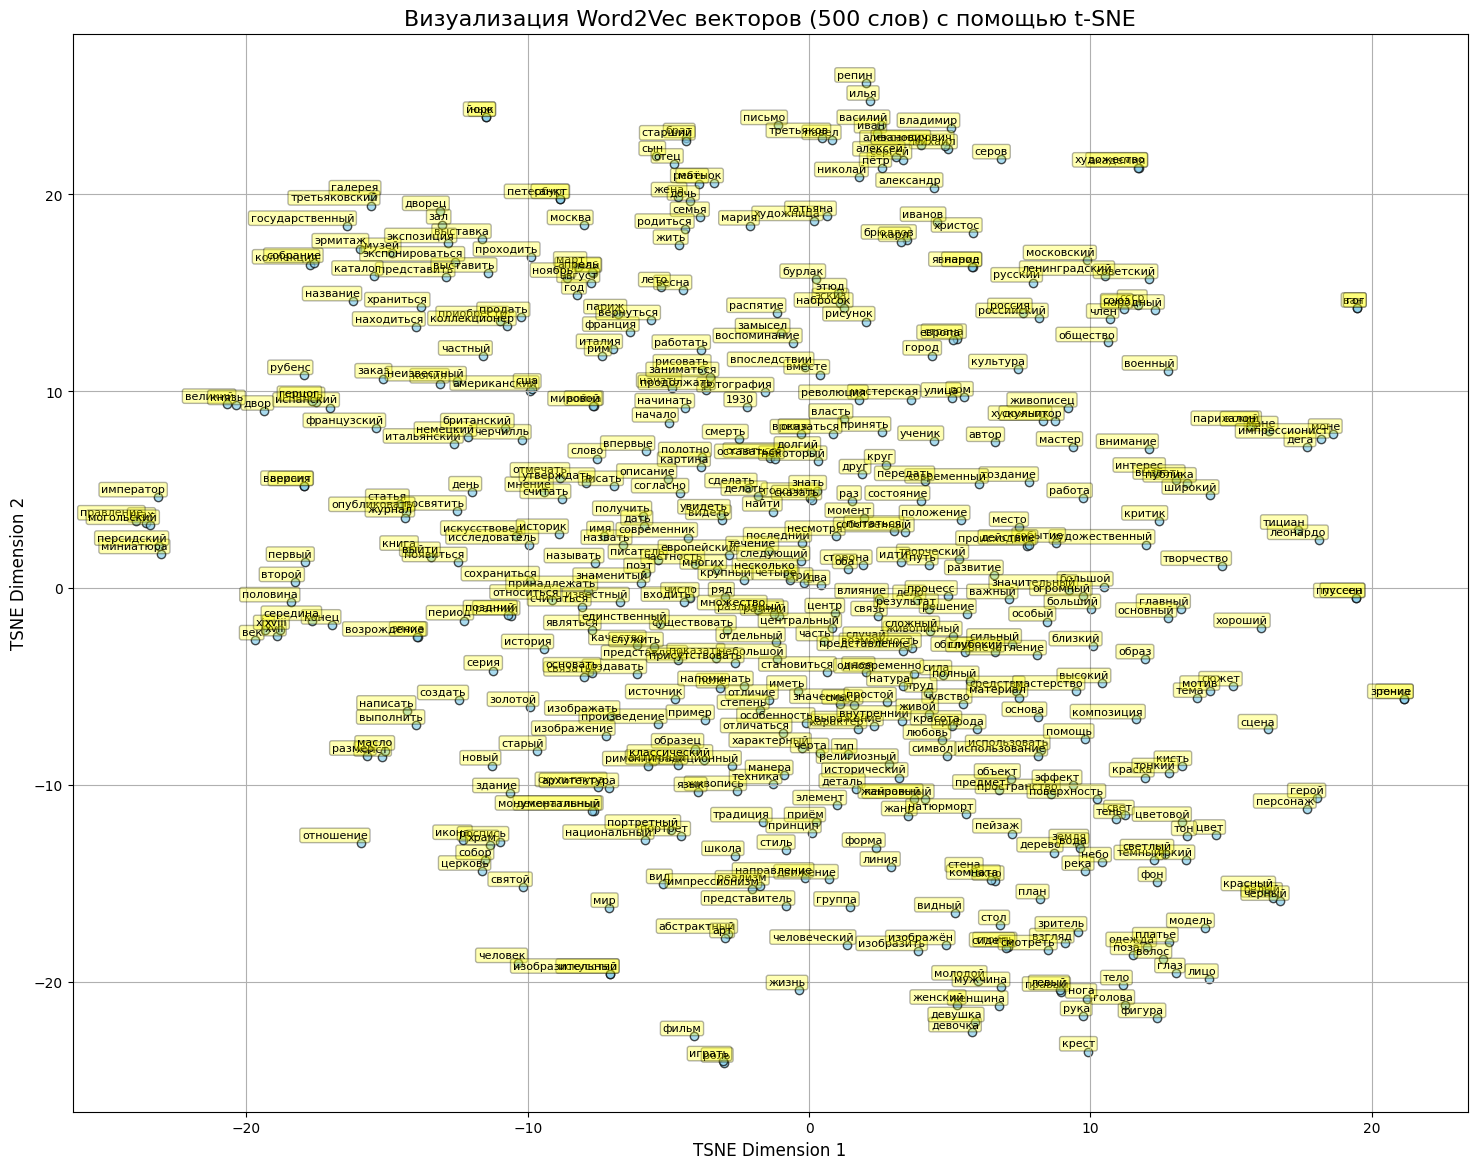


Визуализация завершена. Проверьте график выше.


In [ ]:
# Анализ и визуализация модели Word2Vec

model_path = "word2vec_painting_model.bin"

# Загружаем модель
print(f"Загружаем модель Word2Vec из: '{model_path}'...")
try:
    model = Word2Vec.load(model_path)
    print("Модель успешно загружена.")


print("\n--- Поиск ближайших слов ---")

test_words = ["картина", "художник", "цвет", "выставка", "музей", "рисунок"] # Добавьте свои слова

for word_to_find in test_words:
    if word_to_find in model.wv:
        print(f"\nСлова, похожие на '{word_to_find}':")
        try:
            for word, similarity in model.wv.most_similar(word_to_find):
                print(f"  {word}: {similarity:.3f}")
        except KeyError: # Может произойти, если слова нет, но мы уже проверили
            print(f"  Произошла ошибка при поиске похожих слов для '{word_to_find}'.")
    else:
        print(f"\nСлово '{word_to_find}' не найдено в словаре модели.")
    print("-" * 30)

# Визуализация с помощью t-SNE
print("\n--- Визуализация векторов слов ---")

# Собираем список всех слов и их векторов из модели
words = []
vectors = []
for word in model.wv.key_to_index:
    words.append(word)
    vectors.append(model.wv[word])

vectors = np.array(vectors)

# Выбираем подмножество слов для визуализации, чтобы график не был перегружен.
# Лучше брать около 300-500 слов для наглядности.
num_words_to_visualize = min(500, len(words)) # Возьмем максимум 500 слов или все, если их меньше

if len(words) > num_words_to_visualize:
    # Берем N наиболее частотных слов для лучшего представления
    # (gensim.models.word2vec.Word2Vec.wv.key_to_index уже отсортирован по частоте)
    plot_words = words[:num_words_to_visualize]
    plot_vectors = vectors[:num_words_to_visualize]
else:
    plot_words = words
    plot_vectors = vectors

print(f"Визуализируем {len(plot_words)} слов с помощью t-SNE (это может занять некоторое время)...")

# Применяем t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
vectors_2d = tsne.fit_transform(plot_vectors)

# Создаем график
plt.figure(figsize=(18, 14)) # Увеличенный размер для лучшей читаемости

# Добавляем точки на график
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], edgecolors='k', c='skyblue', alpha=0.7)

# Добавляем текстовые метки для каждого слова
for i, word in enumerate(plot_words):
    plt.annotate(word,
                 xy=(vectors_2d[i, 0], vectors_2d[i, 1]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom',
                 fontsize=8,
                 bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3))

plt.title(f'Визуализация Word2Vec векторов ({len(plot_words)} слов) с помощью t-SNE', fontsize=16)
plt.xlabel("TSNE Dimension 1", fontsize=12)
plt.ylabel("TSNE Dimension 2", fontsize=12)
plt.grid(True)
plt.show()

print("\nВизуализация завершена. Проверьте график выше.")

Модель эффективно улавливает контекстуальные связи. Например, для слова "выставка" она предсказывает такие связанные термины, как "открыться", "приурочить", "передвижной" и "экспонироваться", что напрямую отражает аспекты организации выставок.
Специализированные термины и их окружение. При запросе слова "музей" модель выдаёт аббревиатуры и названия других музеев/организаций ("гмии", "орсе", "радищев"), а также связанные понятия вроде "музейный" и "заповедник". Это показывает, что модель усвоила специфическую лексику предметной области.

